# Classificador Binário
## Support Vector Machine

In [519]:
# Bibliotecas Utilizadas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import plotly.graph_objects as go
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import warnings
from sklearn.ensemble import BaggingClassifier
from itertools import cycle
from scipy import interp
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, mean_squared_error
import IPython
from IPython.display import display, Javascript
from docx2pdf import convert
from docx import Document
from docx.shared import RGBColor
from docx.shared import Inches
import functions as fun
import oci
import boto3
from sklearn.preprocessing import StandardScaler

# Ignorar os avisos de Warnings
warnings.filterwarnings('ignore')

## Buckets Configurations and Functionalities - Oracle Cloud

In [ ]:
# Função para configurações da Cloud
def config_cloud(flag):

    # Definição de variável URL de acesso ao Endpoint Oracle Cloud
    if flag == 'p':
        # Ambiente de Produção - Config Cloud
        url = "https://grinqewrovfi.compat.objectstorage.sa-saopaulo-1.oraclecloud.com" 
    
    elif flag =='t':
        
        # Ambiente de Testes - Config Cloud
        url = "https://grwbzp0j0zza.compat.objectstorage.sa-saopaulo-1.oraclecloud.com"

    # Chamada de função para obter as configurações da Cloud
    fun.configuration_Cloud()

    # Chamada de função para obter o resource
    resource_value = fun.resource()
       
    return url, resource_value

# Chamada de função para configurar a Cloud 
url, resource_value = config_cloud('p')

# Print all buckets
for bucket in resource_value.buckets.all():
    print (bucket.name)

In [521]:
# Configuração de Variáveis - Inicialização
contador_pastas = 0

# Parâmetro (Porcentagem de dados para Teste)
teste = .2

# Definição do path de entrada de dados para Treinamento e Teste do Modelo
path_1 = 'aprendizado_maquinas/processar_1/'

# Definição do path de entrada de dados para Teste de Novos Dados
path_2 = 'aprendizado_maquinas/processar_2/'

In [522]:
# Função para pegar os objetos selecionados no bucket
def objects_to_bucket(etapa, flag, bucket, resource_value, url, path):
            
   # Caminho da pasta (principal) de entrada dos dados
    if os.path.exists(path)==False:
        os.makedirs(path)
        
    # Imprimir os buckets encontrados
    try:
        for bucket_name in resource_value.buckets.all():
            print (bucket_name.name)
        print("\n Conexao com sucesso na cloud!!\n")
    except:
        print("Falha de conexao na cloud")
    
    files = fun.getObjectsToBucket(str(bucket), resource_value)

    # Flag 'd' - Processo de download de dados via (API) Boto3
    if flag == 'd':
        # Function call for download file: destination data science workspace - folder db_imagens
        fun.download_to_bucket(str(bucket), url, files, path)
        message = "Download de arquivos com sucesso!!"
    
    # Flag 's' - Processo de sincronismo de dados via (API) rclone
    elif flag == 's':
        try:
            #rclone sync source:path dest:path
            cmd = 'rclone sync ' + str(bucket) + ':' + str(bucket) + ' ' + path 
            os.system(cmd)
            message = "Arquivos sincronizados com successo!!"
        except:
            message = "Erro de sincronismo"
    
    return message, etapa

# Chamada de função para obter objetos selecionados do bucket
message, etapa = objects_to_bucket(1,'s', 'BK-input-data-classification-full', resource_value, url, path_1)
print(message)

BK-classification
BK-feature-selected
BK-feature-vector
BK-images-1
BK-input-data-classification
BK-input-data-classification-full
BK-segmented-images-1
BK-segmented-images-2
BK-segmented-images-selected

 Success conected in cloud!!

Success synchronism files!!


In [523]:
# Rotinas de definição para estruturação dos arquivos

def files_structure(contador_pastas, path):
    
    #------- loop de pastas (monta a estrutura e lê os arquivos em cada caso:) 
    #--------Caso 1: Treinamento e Teste do Classificador=> Lê o bucket com todas as características das imagens
    #--------Caso 2: Nova Predição -> Depois do classificador treinado=> Lê o bucket que tem as características 
    #--------------------------------------------------------------------separadas por imagens dentro de sua pasta.

    # Mostrar a iteração do loop
    print("Iteração Nº: ", contador_pastas)

    # Listar as subpastas dentro da pasta principal (retira arquivo de controle de versão - Git)
    filepaths_1 = [f for f in os.listdir(path) if not f.endswith('.ipynb_checkpoints')]

    # Acesso à pasta a ser trabalhada (no loop), uma por vez, conforme o "contador _pastas"
    path_local = path + filepaths_1[contador_pastas]

    if path == path_1:
        # Definição da pasta de saída do processamento, uma por vez, conforme o "contador _pastas"
        path_out = 'aprendizado_maquinas/output_1/' + filepaths_1[contador_pastas] + '/'
    
    elif path == path_2:
        # Definição da pasta de saída do processamento, uma por vez, conforme o "contador _pastas"
        path_out = 'aprendizado_maquinas/output_2/' + filepaths_1[contador_pastas] + '/'

    # Criar a pasta "output" de acordo com a imagem de trabalho (na iteração atual do loop)
    # Criar uma estrutura espelho de pastas de "saída", de acordo com a estrutura da pasta de "entrada"
    os.makedirs(path_out)

    # Estrutura que armazena o "path"  (atual) contido em cada pasta a ser trabalhada (no loop)
    filepaths = [f for f in os.listdir(path_local) if f.endswith('.csv')]
    # A partir do path (incompleto) monta o path (completo)
    filepaths = [os.path.join(path_local, name) for name in filepaths]
    print(filepaths)

    #-------------------------------------------------------------------------------------

    # A partir dos dados no formato (.csv) dos arquivos das 3 classes: Verde, Amarela e Marrom de cada imagem
    #   unir os dados de caracaterísticas geradas para processamento do classificador
    df=pd.DataFrame()
    df = pd.concat(map(pd.read_csv, filepaths))
    df.columns = ['A0','A1','A2','A3','A4','A5','A6','A7','A8','A9','C']
    
    gerarGraficos(df)

    # Criar um dataframe para armazenamento dos dados para classificação binária
    #   onde (0: significa não ter a doença -> 1: significa a presença da doença)
    df_bin = pd.DataFrame()
    df_bin = df.copy()

    # Gravar os concatenados no dataframe (com as informações originais das 3 classes) em disco
    df.to_csv(path_out + 'dados_PCA_' + filepaths_1[contador_pastas] + '_.csv', index = None, header=True)
    # Function call Upload files function from workspace files to Selected Bucket
    fun.upload_from_bucket('BK-classification', url, path_out + 'dados_PCA_' + filepaths_1[contador_pastas] + '_.csv')
        
    return df_bin, filepaths_1, path_out

In [524]:
# Gerar o gráfico para visualização dos dados
def gerarGraficos(df_bin):
    g = sns.PairGrid(df_bin, vars=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9'],
                     hue='C', palette='RdBu_r')
    g.map(plt.scatter, alpha=0.9)
    g.add_legend();
    
    h = sns.lmplot('A1', 'A2', col='C', hue='C', data=df_bin,
                   markers=".",  scatter_kws=dict(color='blue'))
    i = sns.lmplot('A3', 'A4', col='C', data=df_bin,
                   markers=".", scatter_kws=dict(color='orange'))
    j = sns.lmplot('A6', 'A6', col='C', data=df_bin,
                   markers=".", scatter_kws=dict(color='yellow'))
    k = sns.lmplot('A7', 'A8', col='C', data=df_bin,
                   markers=".", scatter_kws=dict(color='black'))
    l = sns.lmplot('A9', 'A1', col='C', data=df_bin,
                   markers=".", scatter_kws=dict(color='green'))

In [525]:
# Função para transformação da coluna de Classes: Converter para abordagem binária:
# (Classes 2 (amarela) e 3 (marrom) - As duas tem a doença: deixar como classe '2')
def column_transform(df_bin,path_out,contador_pastas,filepaths_1):
    df_bin['C'] = df_bin['C'].replace([2, 3], int(2))

    # A Classe 1 (verde) - Não tem a doença: deixar como classe '0')
    df_bin['C'] = df_bin['C'].replace([1],int(0))

    # Alterar de Classe 2 para '1' para padronização (1 Tem a doença e 0 não tem a doença)
    df_bin['C'] = df_bin['C'].replace([2],int(1))
    
    # Normalizando o dataframe.
    #df_bin= (df_bin-df_bin.min())/(df_bin.max()-df_bin.min())

    # Gravar os concatenados no dataframe (com as informações alteradas para o contexto binário) em disco
    df_bin.to_csv(path_out + 'dados_PCA_binaria_' + \
                  filepaths_1[contador_pastas] + '_.csv', index = None, header=True)
    # Function call Upload files function from workspace files to Selected Bucket
    fun.upload_from_bucket('BK-classification', url, path_out + 'dados_PCA_binaria_' + \
                  filepaths_1[contador_pastas] + '_.csv')
    
    return df_bin

In [526]:
# Função para verificação de dados faltantes no dataset
def dadosFaltando():
    #Verificar e imprimir os valores 'Nah' no dataset  
    print(df_bin.isnull().sum(axis=0))   

In [527]:
# Função para definição das colunas e divisão do dataframe para treino e teste
def colunms_dataframe_division():
    features = ['A0','A1','A2','A3','A4','A5','A6','A7','A8','A9']
    target = ['C']
    #X = df_bin[features].to_numpy() alterado
    X = df_bin[features]
    #y = df_bin[target].to_numpy() alterado
    y = df_bin[target]

    x_tr, x_te, y_tr, y_te = train_test_split(X, y,
                                                test_size = teste,
                                                random_state=42, stratify=y)
                                                #stratify=y (mantem a mesma proporção das classes nas divisões)
    print(x_tr.shape, x_te.shape)
    
    return x_tr, x_te, y_tr, y_te

In [528]:
# Mostra o número correspondente para cada classe nos dados de teste
#print(np.sum(y_tr==0))
#print(np.sum(y_tr==1))

In [529]:
# Cálculo de Estimativas para o Classificador (Busca dos melhores parâmetros)

def BaggingClassifierTest(C,gamma,):
    #Aplicação do algoritmo SVM - Binário (Teste de BaggingClassifier)
    n_estimators = 10

    # Teste de instrução
    clf_svm = BaggingClassifier(SVC(kernel='poly', degree= 7, probability=True,
                                   class_weight={0: 0.1, 1: 0.9}, C=C, gamma=gamma), max_samples=10.0 /
                                   n_estimators, bootstrap=True, n_estimators=n_estimators, n_jobs=-1)
    return clf_svm

In [530]:
# Função para treinamento e teste do modelo no classificador SVM (uso de estimativas Gridsearch)
def training_testing_SVM(x_tr, x_te, y_tr, y_te):
    tr_std_svm = []
  
    # Escalar os dados de Treino e Teste
    scaler_x_tr = StandardScaler().fit(x_tr)
    x_tr_scaled = scaler_x_tr.transform(x_tr)
    scaler_x_te = StandardScaler().fit(x_te)
    x_te_scaled = scaler_x_te.transform(x_te)

    # Chamada do Classificador (SVM)
    # clf_svm = svm.SVC(kernel='poly', degree=7, probability=True, gamma=1, C=1, class_weight={0.0: 0.1, 1.0: 0.9})
    clf_svm = BaggingClassifierTest(1,1)

    clf_svm.fit(x_tr_scaled, y_tr.values.ravel()) 
    #clf_svm.fit(x_tr_scaled, y_tr) alterado
    y_true3, y_pred3 = y_te, clf_svm.predict(x_te_scaled)
    scores_svm = cross_val_score(clf_svm, x_tr_scaled, y_tr.values.ravel(), cv=10)
    #scores_svm = cross_val_score(clf_svm, x_tr_scaled, y_tr, cv=10) alterado
    tr_std_svm.append(np.std(scores_svm))
    accsvm = accuracy_score(y_te, y_pred3)
    mse = mean_squared_error(y_pred3, y_te)
    report = classification_report(y_true3, y_pred3)
    
    return accsvm, tr_std_svm, mse, report, clf_svm, x_tr_scaled, x_te_scaled

In [531]:
# Função para gerar o arquivo de dados resultantes do Classificador
def data_file_generate(teste, accsvm, tr_std_svm, mse, report,filepaths_1,contador_pastas):
    
    # Variável Global para armazenamento das informações durante o processo de classificação
    text =''
    text+="\n---------------------------------------------------------------------------------\n"
    text+="Dados Classificador SVM (Binário) ---> " + "Imagem: " + filepaths_1[contador_pastas]
    text+="\nPorcentagem de " + str(100-(teste*100)) + "% para Treinamento e " + \
        str(teste*100) + "% para Teste"
    text+="\nAcurácia(SVM): " + str(accsvm)
    text+="\nDesvio Padrão(SVM): " + str(tr_std_svm)
    text+="\nMean Squared Error = " + str(mse)
    text+="\n\nRelatório de Classificação:\n" + str(report)
    text+="\n----------------------------------\n"
    
    return text

In [532]:
## Função para Plot da curva ROC - Modelos
def plot_curva_ROC(titulo, fpr, tpr, path_out, contador_pastas, filepaths_1):
  
    plt.title(titulo)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".5"), plt.plot([1, 1] , c=".5")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.savefig(path_out + 'Curva_ROC_' + filepaths_1[contador_pastas] + '.png', format='png')
    # Function call Upload files function from workspace files to Selected Bucket
    fun.upload_from_bucket('BK-classification', url, path_out + 'Curva_ROC_' + filepaths_1[contador_pastas] + '.png')

    plt.show()

# Função para construção da curva ROC
def ROC_curve_build(text, clf_svm, path_out, contador_pastas,filepaths_1):
    # Cabeçalho das informações da Curva ROC
    text+= "Dados Curva ROC \n"

    #Cálculos de Predição - SVM
    probs = clf_svm.predict_proba(x_te_scaled)
    probs = probs[:, 1]

    # Calcular a Curva ROC
    auc = roc_auc_score(y_te, probs)
    fpr, tpr, thresholds = roc_curve(y_te, probs)

    # Informação gerada do Cálculo da Curva ROC
    text+='AUC(Area Under the Curve - SVM): %.2f\n' % auc

    # Chamada de função para plotagem da Curva ROC
    plot_curva_ROC('Curva ROC - SVM',fpr,tpr,path_out,contador_pastas,filepaths_1)

    # Finalização do cabeçalho
    text+= "---------------------------------------------------------------------------------\n"
    
    return text

In [533]:
# Plot Matrix de Confusão

def plot_matrix(y_tr, y_tr_pred, title, path_out,contador_pastas,filepaths_1):
    cm = confusion_matrix(y_tr, y_tr_pred, normalize=None)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Negativo','Positivo'])
    cmd.plot(values_format='d')
    plt.title(title)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    
    plt.savefig(path_out + 'Matriz_Confusão_' + filepaths_1[contador_pastas] +\
            '.png', format='png')
    # Function call Upload files function from workspace files to Selected Bucket
    fun.upload_from_bucket('BK-classification', url, path_out + 'Matriz_Confusão_' +\
                            filepaths_1[contador_pastas] + '.png')
          
    plt.show()

# Função para construir a matriz de confusão
def confusion_matrix_build(path_out,contador_pastas,filepaths_1):
    y_tr_pred3 = cross_val_predict(clf_svm, x_tr, y_tr.values.ravel(), cv=5)
    #y_tr_pred3 = cross_val_predict(clf_svm, x_tr, y_tr, cv=5) alterado
    plot_matrix(y_tr, y_tr_pred3, 'Matriz - SVM', path_out, contador_pastas, filepaths_1)

In [534]:
#Função para gravar a String de informações do processo em arquivo
def file_save_string(filepaths_1, contador_pastas, text, path_out):
    
    with open(path_out + 'analise_classificadores_' + filepaths_1[contador_pastas] + \
              '_'+ str(100-(teste*100)) + '_Treino_' + str(teste*100) + '_Teste.txt', 'w') as f:
        f.write(text)
       
    return text

In [535]:
# Função para gravar documento (formato .docx) contendo o relatório e as imagens
def document_save_docx(text,path_out,contador_pastas,filepaths_1):
    # Matriz de Confusão e Curva ROC
    document = Document()
    p = document.add_paragraph(text)
    r = p.add_run()
   
    r.add_picture(path_out + 'Curva_ROC_' + filepaths_1[contador_pastas] + \
                  '.png',width=Inches(3.5), height=Inches(2.7))
    r.add_picture(path_out + 'Matriz_Confusão_' + filepaths_1[contador_pastas] + \
                  '.png',width=Inches(2.5), height=Inches(1.7))
    
    r.add_text('---------------------------------------------------------------------------------')

    document.save(path_out + 'analise_classificador_SVM_binario' + \
                  filepaths_1[contador_pastas] + '_'+ str(teste*100) + \
                  '_Teste_' + str(100-(teste*100)) + '_Treino.docx')

    # Function call Upload files function from workspace files to Selected Bucket
    fun.upload_from_bucket('BK-classification', url, path_out + 'analise_classificador_SVM_binario' + \
                  filepaths_1[contador_pastas] + '_'+ str(teste*100) + \
                  '_Teste_' + str(100-(teste*100)) + '_Treino.docx')

In [536]:
# Configuração para Teste de Novos Dados de Entrada

def novosDados(contador_pastas,clf_svm):
    
    # Execução de loop de acordo com a quantidade de imagens para processamento
    for i in range(0,53): # range = quantidade de pastas disponíveis no bucket 'BK-input-data-classification'
    
        # Chamada de função para obter objetos selecionados do bucket que contém
        #    os dados de todas as imagens separadas em pastas individuais
        message, etapa = objects_to_bucket(1,'s', 'BK-input-data-classification', resource_value, url, path_2)
        print(message)

        # Chamada de função para estruturação de arquivos
        # Configuração dos parâmetros de estruturas de pastas e buckets para entradas de Novos Dados
        df_bin, filepaths_1, path_out = files_structure(contador_pastas, path_2)

        # Chamada de função para transformação de colunas
        df_bin = column_transform(df_bin,path_out,contador_pastas,filepaths_1)

        # Visualizar dados faltantes 'Missing values'
        dadosFaltando()

        ###-------------------------------------------------------------------------------------
        # A partir do objeto do Classificador SVM (já Treinado com os dados de todas as imagem)
        text_dados=''
        text_dados+= "Dados da Imagem: " + str(filepaths_1[contador_pastas]) + "\n\n"
        # Ler o arquivo da imagem atual
        df_atual = pd.DataFrame()
        df_atual = pd.read_csv(path_out + 'dados_PCA_' + filepaths_1[contador_pastas] + '_.csv')
        
        # Retirar a coluna 'C' do Dataframe que corresponde ao "target" no processo de
        #   divisão dos dados de Treino e Teste do Classificador
        # Conversão de Dataframe para Array Numpy (intensão de mandar um bloco)
        df_atual = df_atual.drop(columns=['C']).to_numpy()
        
        # Escalar o valor do conjunto de dados de cada imagem
        scaler_img = StandardScaler().fit(df_atual)
        df_atual_scaled = scaler_img.transform(df_atual)
        
        # Predizer o valor de cada imagem
        new_y_pred = clf_svm.predict(df_atual_scaled)
        text_dados+=("Valor da Predição: \n" + str(new_y_pred))
        text_dados+="\n\n--------------------------------------------------------------"
        
        # Salvar o resultado da Predição de cada imagem
        file_save_string(filepaths_1, contador_pastas, text_dados, path_out)
        
        # Incremento do contador de pastas
        contador_pastas+=1
          
    return df_atual, df_atual_scaled, new_y_pred, text_dados

Iteração Nº:  0
['aprendizado_maquinas/processar_1/Full-PCA/DSC_0035_img_escolhida_label_2_verde_DSC_0035.jpg_dados_PCA_112.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0048_img_escolhida_label_2_amarela_DSC_0048.jpg_dados_PCA_152.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0019_img_escolhida_label_2_amarela_DSC_0019.jpg_dados_PCA_107.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0169_img_escolhida_label_1_verde_DSC_0169.jpg_dados_PCA_162.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0040_img_escolhida_label_4_marrom_DSC_0040.jpg_dados_PCA_63.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0038_img_escolhida_label_2_verde_DSC_0038.jpg_dados_PCA_179.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0172_img_escolhida_label_2_marrom_DSC_0172.jpg_dados_PCA_150.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0040_img_escolhida_label_5_verde_DSC_0040.jpg_dados_PCA_128.csv', 'aprendizado_maquinas/processar_1/Full-PCA/DSC_0050_img_escolhida_label_5_

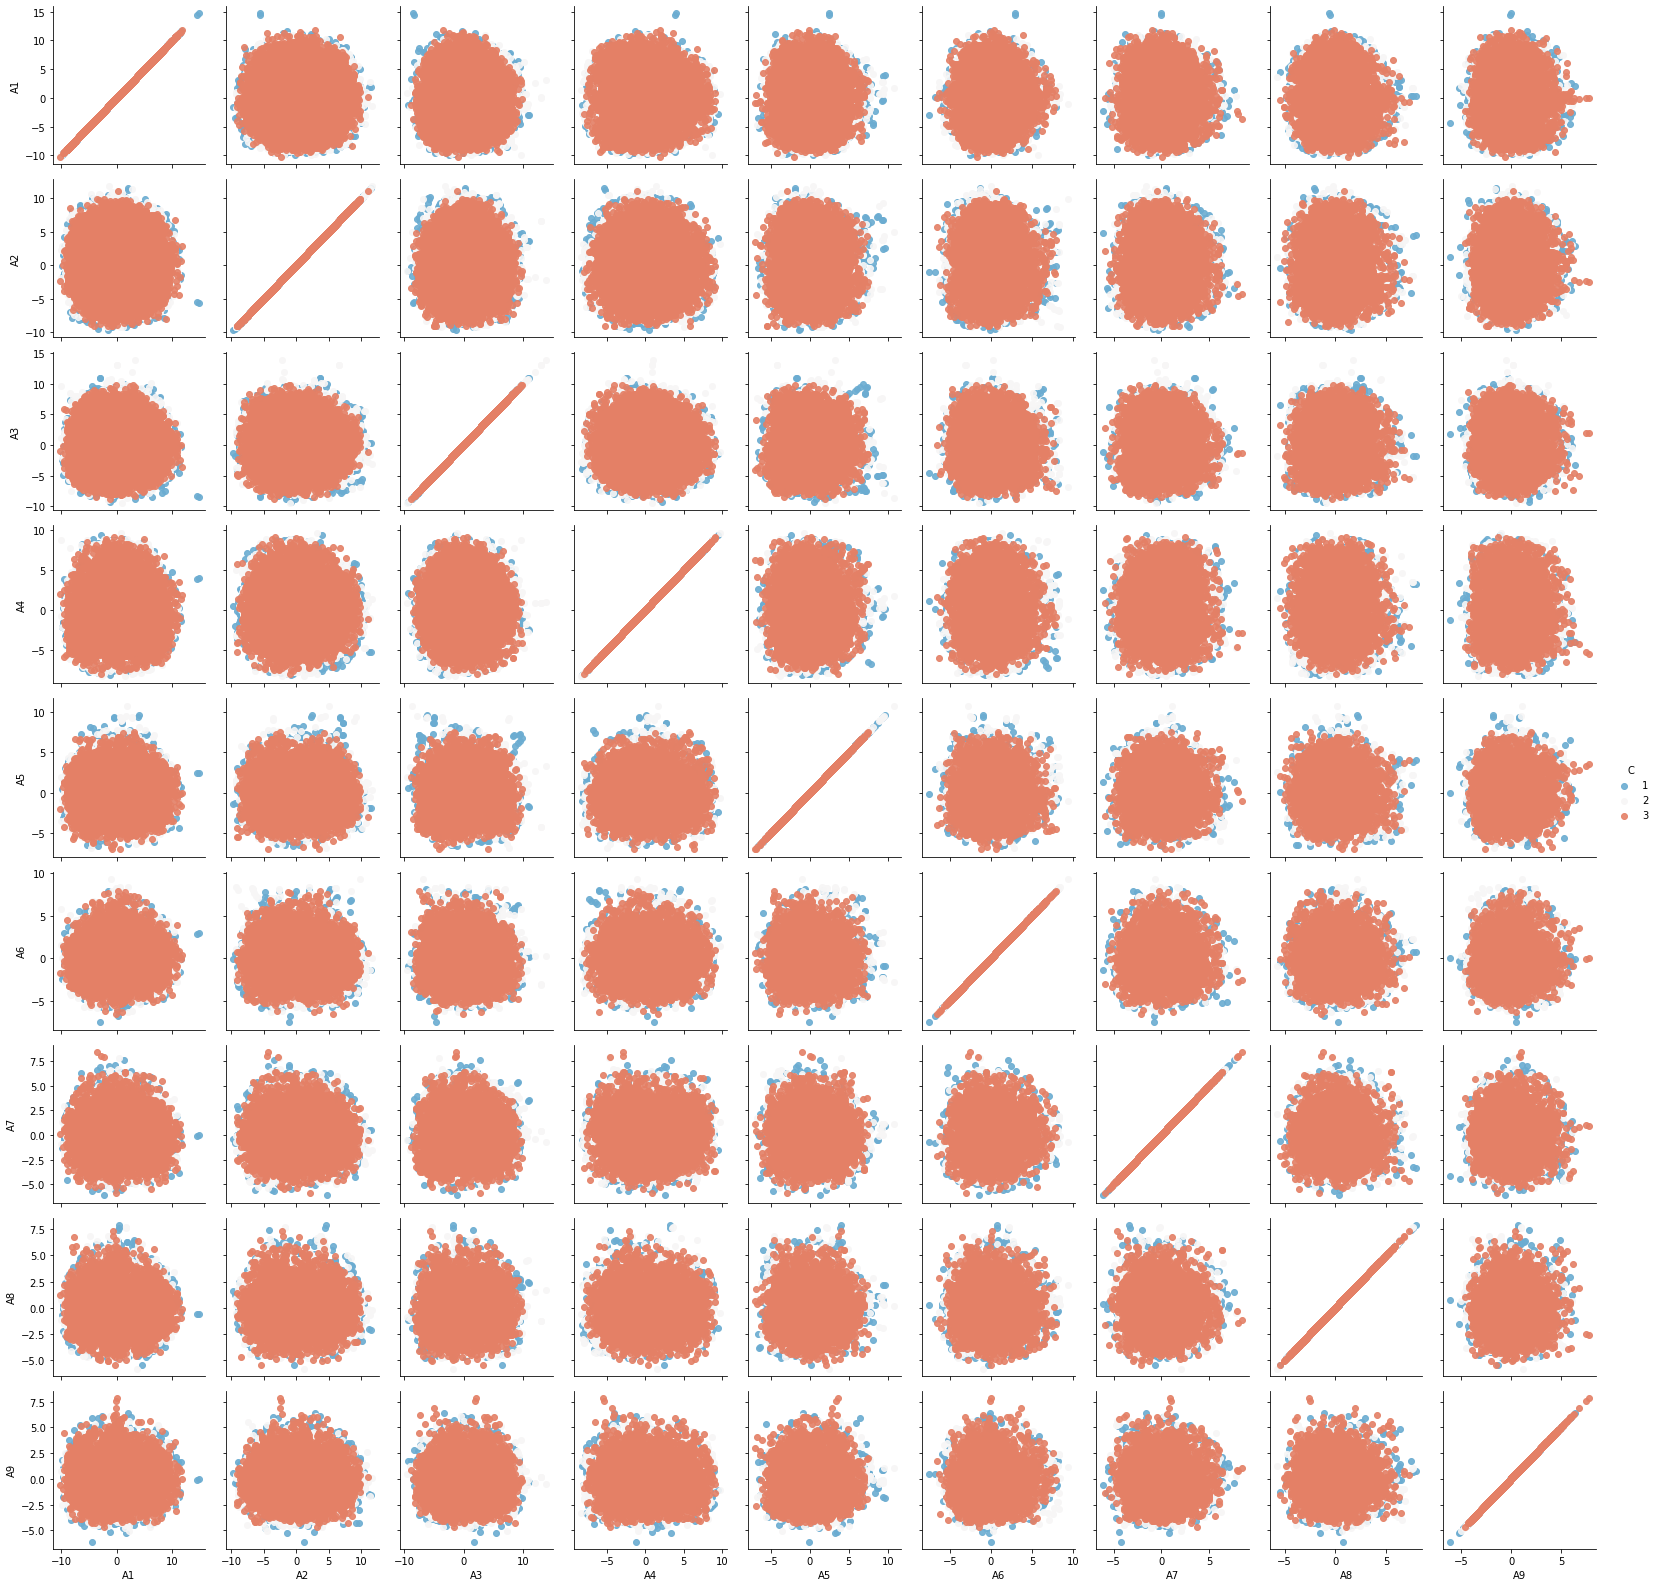

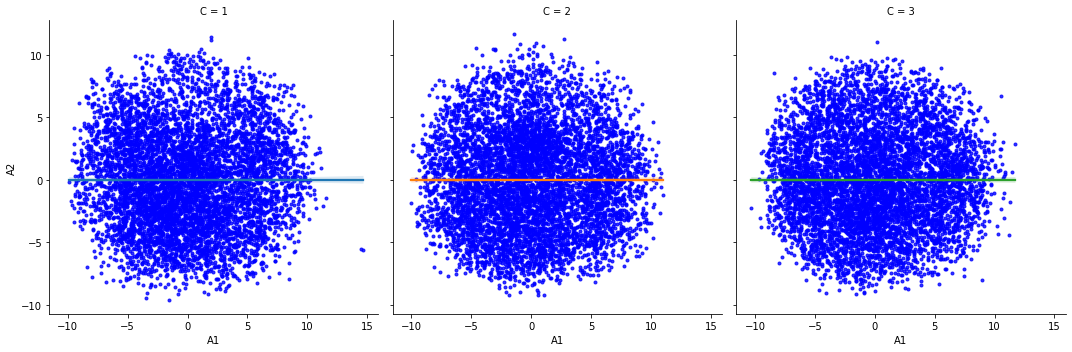

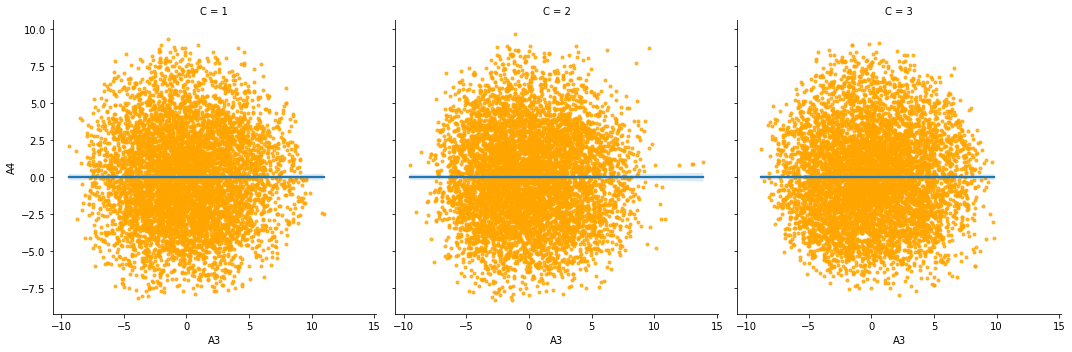

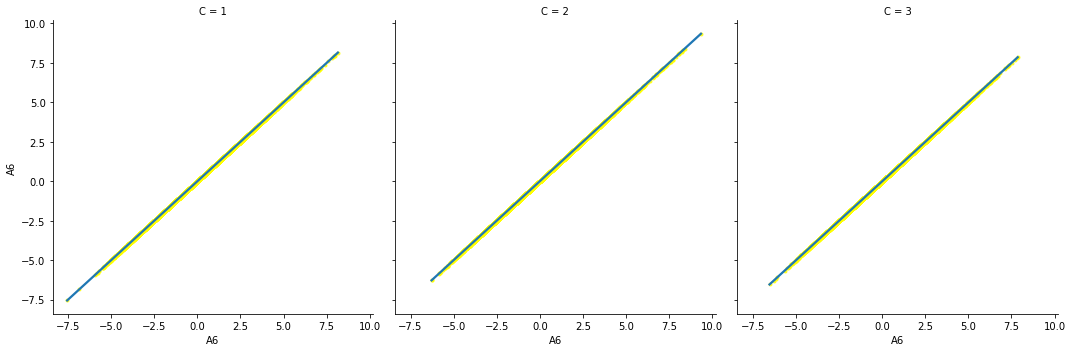

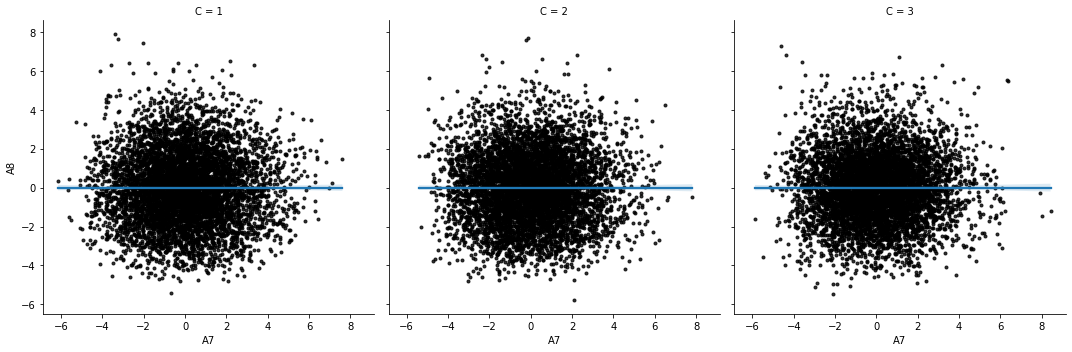

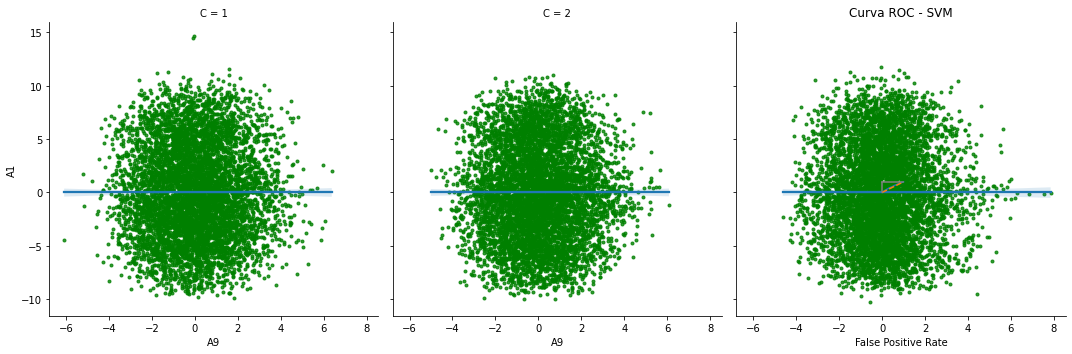

In [537]:
# Chamada para execução do Processo de Treino e Teste do Classificador
    
# Chamada de função para estruturação de arquivos
df_bin, filepaths_1, path_out = files_structure(contador_pastas, path_1)

# Chamada de função para transformação de colunas
df_bin = column_transform(df_bin,path_out,contador_pastas,filepaths_1)

# Visualizar dados faltantes 'Missing values'
dadosFaltando()

#Chamada de função para definição das colunas e divisão do dataframe para treino e teste
x_tr, x_te, y_tr, y_te = colunms_dataframe_division()

# Chamada de função treino e teste do modelo no classificador SVM
accsvm, tr_std_svm, mse, report, clf_svm, x_tr_scaled, x_te_scaled = training_testing_SVM(x_tr, x_te, y_tr, y_te)

# Chamada de função para gerar o arquivo de dados resultantes do Classificador
text = data_file_generate(teste, accsvm, tr_std_svm, mse, report,filepaths_1, contador_pastas)

# Chamada de função para construção da curva ROC
text = ROC_curve_build(text, clf_svm, path_out, contador_pastas, filepaths_1)

# Chamada de função para construir a matriz de confusão
#confusion_matrix_build(path_out,contador_pastas,filepaths_1)

# Chamada de função para gravar a String de informações do processo em arquivo
text = file_save_string(filepaths_1, contador_pastas, text, path_out)

# Chamada de função para gravar documento .docx
#document_save_docx(text,path_out,contador_pastas,filepaths_1)

# ------------------------------------------------------------------
## Processo de entrada de Novos Dados

# Chamada da Função para Teste de Novos Dados
contador_pastas=0
#df_atual, df_atual_scaled, new_y_pred, text_dados = novosDados(contador_pastas, clf_svm)